## Finding Initial Learning Rate

### Import Modules and Dependencies

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2019) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from google.colab.patches import cv2_imshow

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import Dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

### Dataset Dimensions

In [141]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


### Display Data Samples

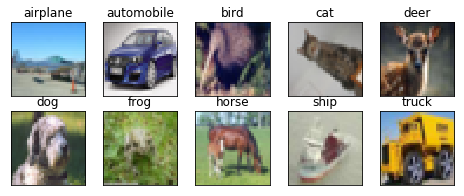

In [142]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Data Conversion, Pixel Normalization and One-hot Encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Learning Rate Finder Class

In [0]:
from keras.callbacks import Callback

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

### Hyperparameters

In [0]:
batch_size = 128
num_classes = 10
epochs = 5

### Model Architecture

In [7]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))

W0717 10:16:14.293927 140018693252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0717 10:16:14.337590 140018693252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 10:16:14.346348 140018693252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 10:16:14.393181 140018693252992 deprecation_wrapper.py

### Model Summary

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Compile model to find initial LR

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0717 08:02:13.342563 139661660952448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Train model to find optimum initial LR 

In [0]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))
model.fit(train_features, train_labels, callbacks=[lr_finder], epochs=3)

W0717 08:02:13.636498 139661660952448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
10880/50000 [=====>........................] - ETA: 1:14 - loss: 3.6237 - acc: 0.2149

### Plots for LR

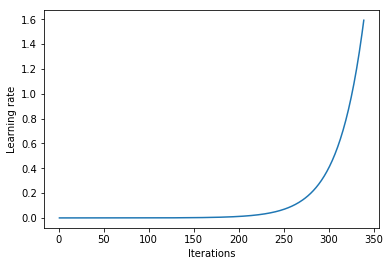

In [0]:
lr_finder.plot_lr()

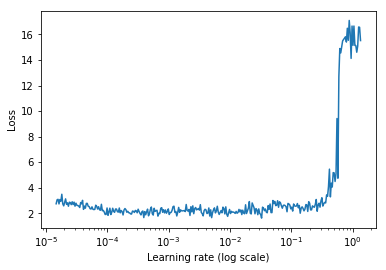

In [0]:
lr_finder.plot()

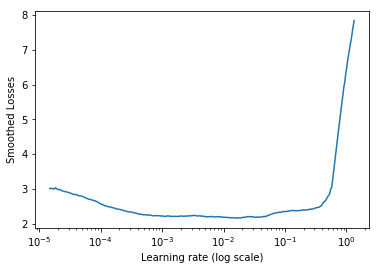

In [0]:
lr_finder.plot_smoothed_loss()

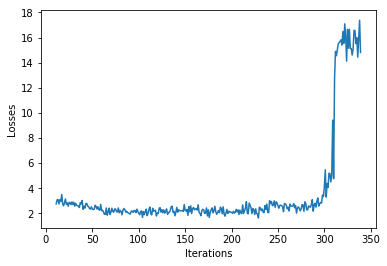

In [0]:
lr_finder.plot_loss()

**From above plots, loss is least around 0.01 learning rate so setting initial LR to 0.01**

---

## Model Training 
Above Model architecture is trained with following:  
- CutOut
- SGD with momentum
- Training and Testing accuracy curves
- Misclassified Images with GradCam

### Functions to Plot Training and Validation Accuracy

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Function for CutOut

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### SGD Optimizer with Momentum

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

### Compile model for training with SGD

In [13]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0717 10:16:54.101610 140018693252992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Model Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=100, validation_data=(array([[[..., verbose=0, steps_per_epoch=390)`
  


Model took 1122.61 seconds to train


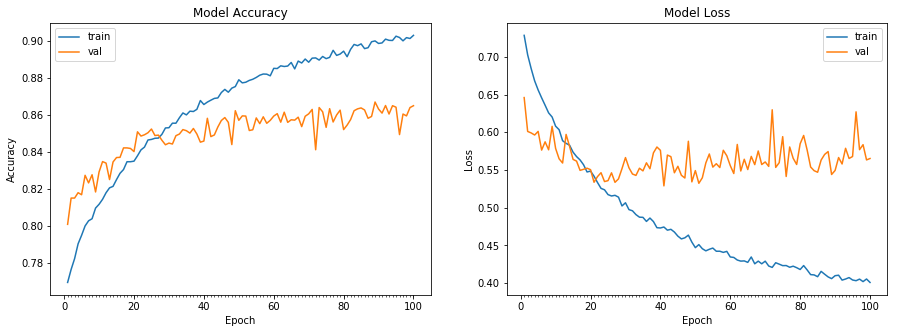

Accuracy on test data is: 86.48


In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)) # CutOut


# train the model
start = time.time()

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], epochs = 100, 
                                 validation_data = (test_features, test_labels), 
                                 verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Validation Accuracy is 86.48%

### Mount Drive

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Save Model 

In [0]:
from keras.models import load_model

filepath="/content/gdrive/My Drive/Colab Notebooks/model-86.hdf5"

model.save(filepath)

### Round-off Predictions

In [54]:
predicted_results = model.predict(test_features)
print(len(predicted_results), "Predicted Classes")

# Rounding off values for one-hot vector
predicted_results = np.round(predicted_results[:])

print(predicted_results[0])
print(test_labels[0])

10000 Predicted Classes
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### Separate correctly classified and misclassified images' indexes

In [0]:
correct_indices = []
incorrect_indices = []

for i in range(len(predicted_results)):
  if np.argmax(test_labels[i]) == np.argmax(predicted_results[i]):
    correct_indices.append(i)
  else:
    incorrect_indices.append(i)

In [57]:
print(len(correct_indices)," classified correctly") 
print(len(incorrect_indices)," classified incorrectly")

8561  classified correctly
1439  classified incorrectly


### 25 Samples of misclassified images

In [59]:
incorrect_index_25 = incorrect_indices[:25]

print(incorrect_index_25)

[24, 32, 35, 37, 58, 59, 61, 68, 78, 85, 95, 106, 118, 125, 128, 143, 145, 147, 162, 169, 171, 178, 183, 188, 197]


### Verification

In [60]:
for i in incorrect_index_25:
  print("Predicted Class Number: ", np.argmax(predicted_results[i]), "\t Actual Class Number: ", np.argmax(test_labels[i]))

Predicted Class Number:  4 	 Actual Class Number:  5
Predicted Class Number:  8 	 Actual Class Number:  4
Predicted Class Number:  0 	 Actual Class Number:  2
Predicted Class Number:  9 	 Actual Class Number:  1
Predicted Class Number:  0 	 Actual Class Number:  4
Predicted Class Number:  0 	 Actual Class Number:  6
Predicted Class Number:  5 	 Actual Class Number:  3
Predicted Class Number:  0 	 Actual Class Number:  3
Predicted Class Number:  5 	 Actual Class Number:  3
Predicted Class Number:  7 	 Actual Class Number:  5
Predicted Class Number:  3 	 Actual Class Number:  6
Predicted Class Number:  6 	 Actual Class Number:  3
Predicted Class Number:  6 	 Actual Class Number:  2
Predicted Class Number:  2 	 Actual Class Number:  0
Predicted Class Number:  3 	 Actual Class Number:  5
Predicted Class Number:  5 	 Actual Class Number:  3
Predicted Class Number:  0 	 Actual Class Number:  7
Predicted Class Number:  5 	 Actual Class Number:  2
Predicted Class Number:  3 	 Actual Class Numb

### GradCam Function

In [0]:
def viz(input_img, layer_name, channel_number):
  x = image.img_to_array(input_img)
  x = preprocess_input(x)
  x = np.expand_dims(x, axis=0)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channel_number):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (input_img.shape[1], input_img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#   heatmap = np.asarray(heatmap, np.float32)
#   superimposed_img = cv2.addWeighted(input_img, 0.6, heatmap, 0.4, 0)
  
  return heatmap

### Debugging

In [0]:
# for i in range(len(incorrect_index_25)-20):
  
#   preprocess_img = image.img_to_array(test_features[incorrect_index_25[i]])
#   preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
  
#   out = viz(preprocess_img, layer_name="conv2d_8", channel_number=256)
#   out = cv2.addWeighted(test_features[incorrect_index_25[i]], 0.6, out, 0.4, 0)

# #   print("Activation Image -", i+1, ": ")
#   disp(out)
  
# print(preprocess_img.shape[:])
# print(out.shape[:])
# print(test_features[incorrect_index_25[i]].shape[:])

### Plot of misclassified images with model predictions and labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


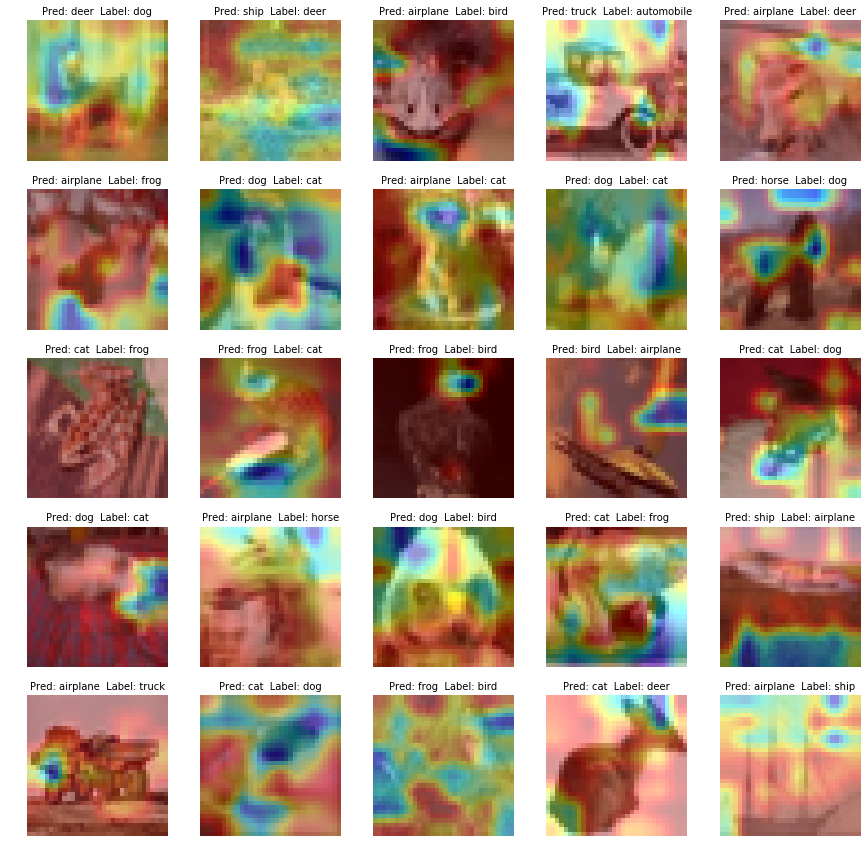

In [193]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 5
val = 0

for i in range(1, columns*rows +1):
  if len(incorrect_index_25) >= i:
    index = incorrect_index_25[val]
#     print(np.argmax(test_labels[index]))
    img = test_features[incorrect_index_25[val]]
    img = img.reshape((32,32,3))
    
    preprocess_img = image.img_to_array(img)
    preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_BGR2RGB)
  
    out = viz(preprocess_img, layer_name="conv2d_8", channel_number=256)
    out = cv2.addWeighted(img, 0.6, out, 0.4, 0)
    
    fig.add_subplot(rows, columns, i)
    plt.title('Pred: '+ str(class_names[np.argmax(predicted_results[index])]) + "  Label: " + str(class_names[test_labels[index][0]]), fontsize=10)
    plt.imshow(out)
    plt.axis('off')
    val += 1
  else:
    pass
plt.show()